In [1]:
%matplotlib inline
import sys
sys.path.append("../../")
import numpy as np
from simulator import AnalogCore
from simulator import CrossSimParameters
from applications.mvm_params import set_params
import scipy.linalg
import matplotlib
import matplotlib.pyplot as plt
import pickle
from PIL import Image
np.random.seed(498)

# Convert to decibels relative to full scale (dBFS)
def dbfs_rgb(x):
    maxVal = np.max(x)
    db_R = 20*np.log10((x[:,:,0] + np.finfo(float).eps)/maxVal)
    db_G = 20*np.log10((x[:,:,1] + np.finfo(float).eps)/maxVal)
    db_B = 20*np.log10((x[:,:,2] + np.finfo(float).eps)/maxVal)
    return [db_R, db_G, db_B]

# Application co-design with CrossSim

In this notebook, we will show some examples of how we can use CrossSim to evaluate the accuracy of analog processing-using-memory (PUM) on some applications. We will start with the Fourier transform application (Part 1) then evaluate on a neural network application (Part 2).

# Part 1: Discrete Fourier transform (DFT)

## 1.1: Problem setup

The DFT is an operation that is used ubiquitously for many applications. Here, we will demonstrate a 2D DFT which is a crucial component of many image processing workloads. It also has the nice advantage of allowing us to see the effects of simulated errors induced by analog PUM directly as visual artifacts in an image.

First, we will load the "Ichiro" image that will be used for this analysis.

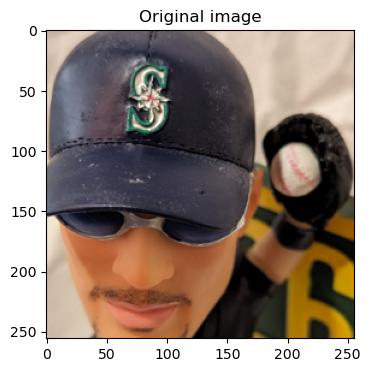

In [2]:
# Load image
N, N, Nch = 256, 256, 3
ichiro = Image.open('../../applications/dsp/example_images/ichiro.jpg').resize((N,N))
ichiro = np.array(ichiro).astype(np.float32) / 255

# Show image
fig,ax = plt.subplots(1,1,figsize=(4,4))
ax.imshow(ichiro)
ax.set_title("Original image")
plt.show()

For a square $N \times N$ image, the 2D DFT operation is defined by the following equation:

$Y_{j,k} = \sum \limits_{m=0}^{N-1} \sum \limits_{n=0}^{N-1} Y_{m,n} \exp{\left(-i\frac{2\pi}{N}kn\right)} \exp{\left(-i\frac{2\pi}{N}jm\right)}$

Using row-column decomposition, the 2D DFT can be written as two matrix-matrix multiplications applied on the input image:

$\mathbf{Y} = \mathbf{W}_N\mathbf{X}\mathbf{W}_N^T$

where $\mathbf{W}_N$ is the $N$-point DFT matrix, and $\mathbf{X}$ and $\mathbf{Y}$ are the 2D input and output.

After computing the 2D DFT, we can get back the original image by applying the 2D inverse DFT to the computed spectrum. The inverse DFT is evaluated using the same expression as above, but its matrix is the conjugate transpose: $\mathbf{W}_N^H$.

Let's first implement this using NumPy.

In [3]:
# First, create the matrices for the DFT and inverse DFT
W_dft = scipy.linalg.dft(N)
W_idft = np.matrix.getH(W_dft)

# Container for the 2D spectrum and reconstruction
spectrum = np.zeros(ichiro.shape, dtype=np.complex128)
reconstruction = np.zeros(ichiro.shape, dtype=np.complex128)

for ch in range(Nch):

    # Compute 2D DFT
    partial_dft = W_dft @ ichiro[:,:,ch]
    spectrum[:,:,ch] = partial_dft @ W_dft

    # Compute 2D inverse DFT
    partial_idft = W_idft @ spectrum[:,:,ch]
    reconstruction[:,:,ch] = partial_idft @ W_idft

Now let's visualize the computed spectrum and the reconstructed image.

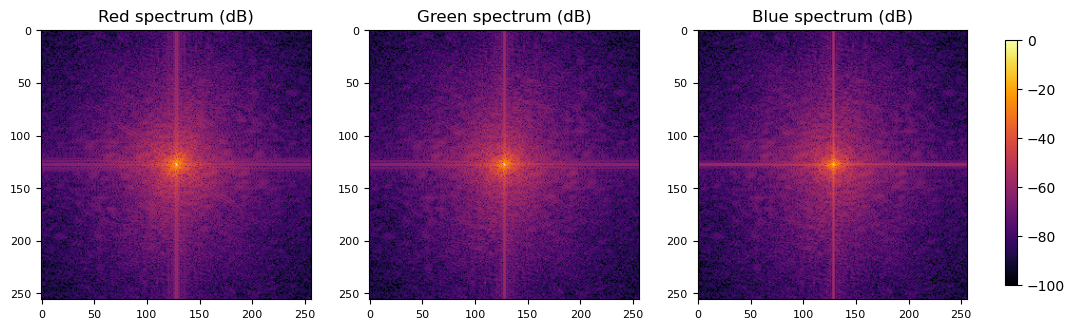

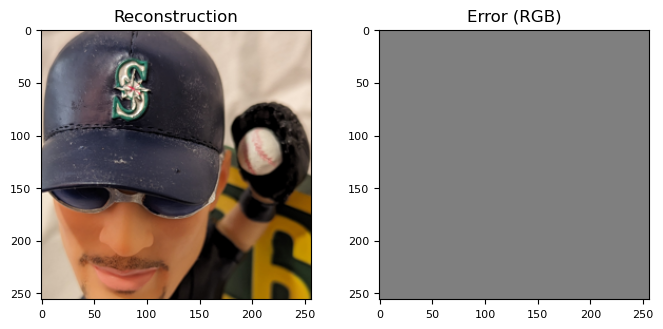

In [4]:
# Express each channel's magnitude spectrum as dBFS (decibels relative to full scale)
mag_spectrum = np.abs(spectrum)
dB_spectrum = dbfs_rgb(mag_spectrum)

# Plot the computed frequency spectrum for each color
fig,axes = plt.subplots(1,3,figsize=(12,3.5))
cmap = matplotlib.colormaps["inferno"]
colors = ["Red","Green","Blue"]
C=[axes[j].imshow(np.fft.fftshift(dB_spectrum[j]), vmin=-100, vmax=0, cmap=cmap) for j in range(3)]
[axes[j].set_title(colors[j]+" spectrum (dB)") for j in range(3)]
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.93, 0.15, 0.01, 0.7])
cbar = fig.colorbar(C[0], cax=cbar_ax)
[ax.tick_params(labelsize=8) for ax in axes]

# Plot the reconstructed image
reconstruction = np.abs(reconstruction)/np.max(np.abs(reconstruction))
error = reconstruction - ichiro + 0.5
fig2,axes2 = plt.subplots(1,2,figsize=(8,3.5))
axes2[0].imshow(reconstruction)
axes2[0].set_title("Reconstruction")
axes2[1].imshow(error)
axes2[1].set_title("Error (RGB)")
[ax.tick_params(labelsize=8) for ax in axes2]
plt.show()


## 1.2 Configuring and adding errors to the AnalogCore

Next, we'll make things more interesting by making our AnalogCore more physically realistic. We'll look directly at the conductances stored inside the core and see how errors in these conductances affect the quality of images we get using the 2D DFT.

__Negative number representation__: One of the first questions that comes up when we design an analog PUM system is: how do we map a matrix containing negative weights to a crossbar array where the conductances are purely positive? There are multiple ways to do this, but we'll focus here on differential cells, where each weight is encoded by the difference of two conductances.

<img src="./graphics/differential_cells.png" width=300 />

__Conductance programming errors__: The next major consideration is the random programming error in the conductance values. Specifically, how does the amount of random error depend on the conductance state $G$? This characteristic is different for every device, and CrossSim can support an arbitrarily complex, user-defined device error characteristic, as will be shown in the next tutorial.

To keep things simple, we will use one of two generic device error models that are incuded in CrossSim, both of which simulate programming error as a normally distributed random error $\mathcal{N}(0,\sigma_G)$ that is added to the conductance $G$. We will use the __state-proportional__ error model: $\sigma_G = \alpha*G$, where $\alpha$ controls the overall magnitude of the error.

<img src="https://www.sandia.gov/app/uploads/sites/110/2023/09/error_types.png" width=450 />

We will additionally give the following properties to the core:
- Memory device resistance range: 1 k$\Omega$ and 1M$\Omega$
- Bit precision of target weights: 8 bits

The first step is to create CrossSim parameter objects which capture the properties described above. We will create this using the set_params helper function.

In [5]:
# Create the parameters for the core with programming errors
alpha = 0.1
params_alpha = set_params(
                            complex_matrix = True,
                            complex_input = True,
                            weight_bits = 8,
                            wtmodel = "BALANCED",
                            error_model = "generic",
                            proportional_error = True,
                            alpha_error = alpha,
                            Rmin = 1e3,
                            Rmax = 1e6,
                        )

# Also create parameters for a core with the same settings but no programming error, for comparison.
params_ideal = set_params(
                            complex_matrix = True,
                            complex_input = True,
                            weight_bits = 8,
                            wtmodel = "BALANCED",
                            error_model = "none",
                            Rmin = 1e3,
                            Rmax = 1e6,
                        )

Next, we create AnalogCore objects using these parameters.

In [6]:
# Create AnalogCores and program DFT and inverse DFT matrix
xbar_dft_alpha = AnalogCore(W_dft, params = params_alpha)
xbar_idft_alpha = AnalogCore(W_idft, params = params_alpha)
xbar_dft_ideal = AnalogCore(W_dft, params = params_ideal)
xbar_idft_ideal = AnalogCore(W_idft, params = params_ideal)

Let's look under the hood at the crossbar of conductances that are used to store this matrix. Note that although we have plotted the positive and negative parts separately. The decomposition of the real and imaginary parts of the DFT matrix is handled automatically by CrossSim.

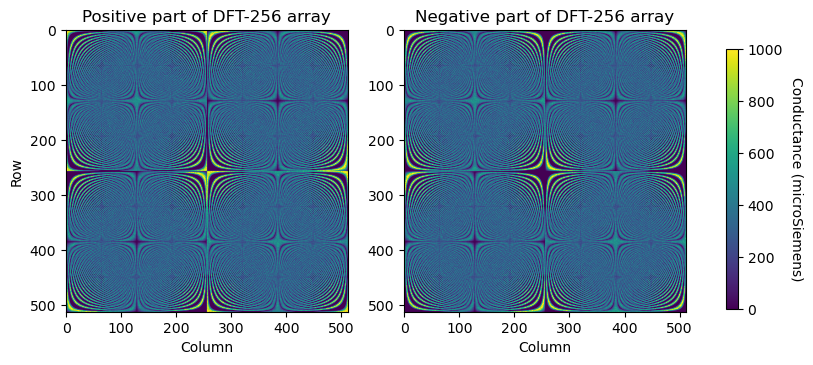

In [7]:
# Conductance arrays for non-ideal core
G_pos_alpha = xbar_dft_alpha.cores[0][0].core_pos.matrix / params_alpha.xbar.device.Rmin
G_neg_alpha = xbar_dft_alpha.cores[0][0].core_neg.matrix / params_alpha.xbar.device.Rmin

# Conductance arrays for ideal core
G_pos_ideal = xbar_dft_ideal.cores[0][0].core_pos.matrix / params_ideal.xbar.device.Rmin
G_neg_ideal = xbar_dft_ideal.cores[0][0].core_neg.matrix / params_ideal.xbar.device.Rmin

# Plot
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(8,4))
C1=ax1.imshow(G_pos_alpha/1e-6, vmin=0, vmax=1e3)
ax2.imshow(G_neg_alpha/1e-6, vmin=0, vmax=1e3)
ax1.set_title("Positive part of DFT-256 array")
ax2.set_title("Negative part of DFT-256 array")
ax1.set_ylabel("Row")
[ax.set_xlabel("Column") for ax in [ax1,ax2]]
[ax.set_aspect("equal") for ax in [ax1,ax2]]
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.95, 0.15, 0.015, 0.65])
cbar = fig.colorbar(C1, cax=cbar_ax)
cbar.set_label("Conductance (microSiemens)",rotation=270,labelpad=15)
plt.show()

This is a pretty large array, so let's just look at the top left corner of the positive array and compare to the ideal case.

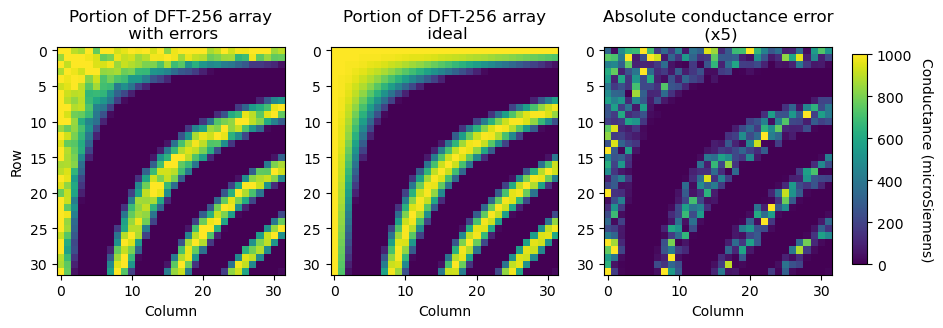

In [8]:
# Plot
fig, axes = plt.subplots(1,3,figsize=(10,3))
fig.subplots_adjust(right=0.9)
G_mats = [G_pos_alpha, G_pos_ideal, 5*np.abs(G_pos_alpha - G_pos_ideal)]
C = [axes[i].imshow(G_mats[i][:32,:32]/1e-6, vmin=0, vmax=1e3) for i in range(3)]
axes[0].set_title("Portion of DFT-256 array\n with errors",fontsize=12)
axes[1].set_title("Portion of DFT-256 array\n ideal",fontsize=12)
axes[2].set_title("Absolute conductance error\n (x5)")
axes[0].set_ylabel("Row")
[ax.set_xlabel("Column") for ax in axes]
[ax.set_aspect("equal") for ax in axes]
cbar_ax = fig.add_axes([0.92, 0.15, 0.015, 0.7])
cbar = fig.colorbar(C1, cax=cbar_ax)
cbar.set_label("Conductance (microSiemens)",rotation=270,labelpad=15)
plt.show()

Now let's simulate the 2D image reconstruction with analog PUM, using the DFT and inverse DFT arrays with conductance errors. This is done by using the same code we wrote to evaluate the 2D DFT with NumPy, and simply replacing the NumPy arrays with AnalogCores!

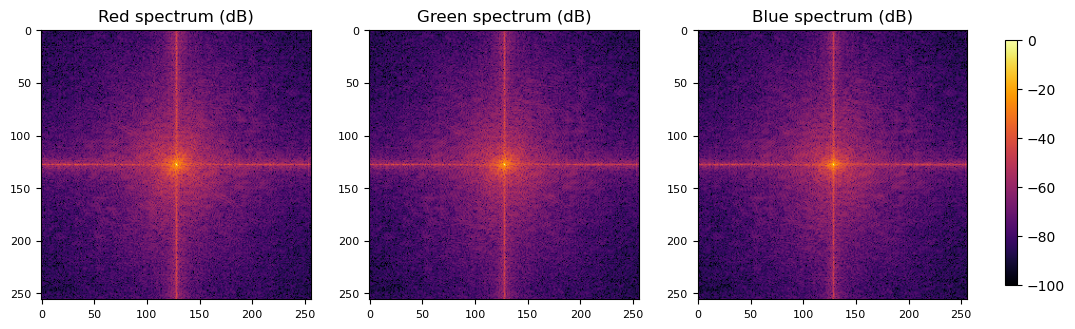

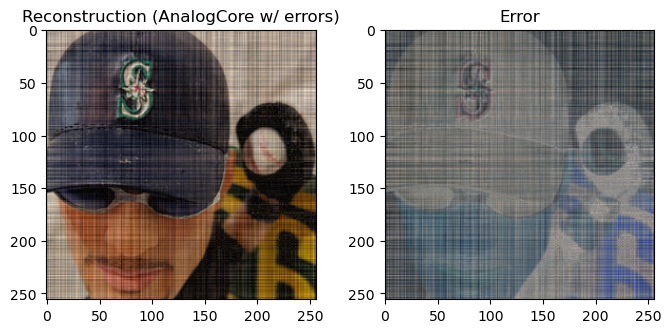

In [9]:
# Container for the 2D spectrum and reconstruction
spectrum_xbar = np.zeros(ichiro.shape, dtype=np.complex128)
reconstruction_xbar = np.zeros(ichiro.shape, dtype=np.complex128)

for ch in range(Nch):

    # Compute 2D DFT
    partial_dft = xbar_dft_alpha @ ichiro[:,:,ch]
    spectrum_xbar[:,:,ch] = partial_dft @ xbar_dft_alpha

    # Compute 2D inverse DFT
    partial_idft = xbar_idft_alpha @ spectrum_xbar[:,:,ch]
    reconstruction_xbar[:,:,ch] = partial_idft @ xbar_idft_alpha

# Express each channel's magnitude spectrum as dBFS (decibels relative to full scale)
mag_spectrum_xbar = np.abs(spectrum_xbar)
dB_spectrum_xbar = dbfs_rgb(mag_spectrum_xbar)

# Plot the spectrum
fig,axes = plt.subplots(1,3,figsize=(12,3.5))
cmap = matplotlib.colormaps["inferno"]
colors = ["Red","Green","Blue"]
C=[axes[j].imshow(np.fft.fftshift(dB_spectrum_xbar[j]), vmin=-100, vmax=0, cmap=cmap) for j in range(3)]
[axes[j].set_title(colors[j]+" spectrum (dB)") for j in range(3)]
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.93, 0.15, 0.01, 0.7])
cbar = fig.colorbar(C[0], cax=cbar_ax)
[ax.tick_params(labelsize=8) for ax in axes]

# Plot the reconstructed image
reconstruction_xbar = np.abs(reconstruction_xbar)/np.max(np.abs(reconstruction_xbar))
error = reconstruction_xbar - ichiro + 0.5
fig,axes = plt.subplots(1,2,figsize=(8,3.5))
axes[0].imshow(reconstruction_xbar)
axes[0].set_title("Reconstruction (AnalogCore w/ errors)")
axes[1].imshow(error)
axes[1].set_title("Error")
[ax.tick_params(labelsize=8) for ax in axes2]
plt.show()

We see artifacts appearing in the reconstructed image because of the conductance errors. These artifacts are in the form of horizontal and vertical streaks because each column of weights in the DFT matrix contributes to one row or column of values in the matrix-matrix product. The same is true for the inverse DFT.

## 1.3 Weight bit slicing

Another design choice related to algorithm-to-hardware mapping is related to the representation of bit precision. In the previous examples, we encoded 8-bit weights in the state(s) of one or a pair of devices, which were assumed to have at least 128 target-able memory states.

We could also choose to split the bit precision across multiple devices, with fewer bits encoded per device. This is called bit slicing. In the example below, we use balanced core with four slices to represent 8-bit weights.

Below is a pictorial representation of bit slicing:
<br />
<br />


<img src="https://www.sandia.gov/app/uploads/sites/110/2023/09/bit_slicing.png" width=500 />

Note that in the scheme above, because each slice is made up of a pair of 2-bit devices, it actually encodes three bits: two magnitude bits and a sign bit. Taking the four slices together, we actually have the range to represent 9-bit weights: eight magnitude bits and a sign bit.

Let's create an AnalogCore with the same device properties as the example we used above, but uses bit slicing.

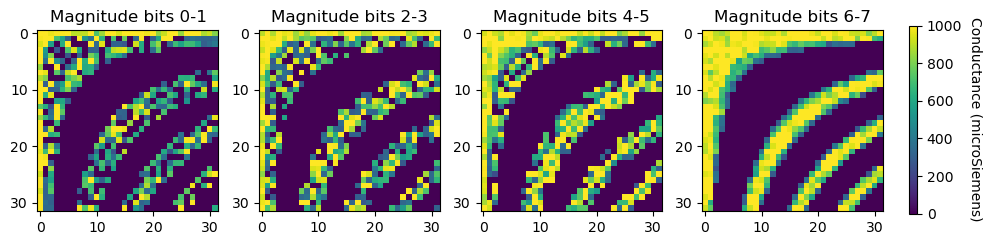

In [10]:
# Create the parameters for the core with programming errors
Nslices = 4
params_bitsliced = set_params(
                            complex_matrix = True,
                            complex_input = True,
                            weight_bits = 9,
                            Nslices = Nslices,
                            wtmodel = "BALANCED",
                            error_model = "generic",
                            proportional_error = True,
                            alpha_error = alpha,
                            Rmin = 1e3,
                            Rmax = 1e6)

xbar_dft_bitsliced = AnalogCore(W_dft, params = params_bitsliced)
xbar_idft_bitsliced = AnalogCore(W_idft, params = params_bitsliced)

# Get slice conductance matrices
G_slices = [None for i in range(Nslices)]
for i in range(Nslices):
    G_pos = xbar_dft_bitsliced.cores[0][0].core_slices[i][0].matrix / params_bitsliced.xbar.device.Rmin
    G_neg = xbar_dft_bitsliced.cores[0][0].core_slices[i][1].matrix / params_bitsliced.xbar.device.Rmin
    G_slices[i] = np.concatenate((G_pos, G_neg), axis=1)

# Plot
#fig,axes = plt.subplots(2,2,figsize=(6,5))
#plt.subplots_adjust(hspace=0.35)
#C=[[axes[i][j].imshow(G_slices[2*i+j][:75,:75]/1e-6, vmin=0, vmax=1e3) for j in range(2)] for i in range(2)]
#[[axes[i][j].set_title("Magnitude bits {:d}-{:d}".format(4*i+2*j,4*i+2*j+1), fontsize=13) for j in range(2)] for i in range(2)]
#[[axes[i][j].set_aspect("equal") for j in range(2)] for i in range(2)]
#fig.subplots_adjust(right=0.9)
#cbar_ax = fig.add_axes([0.95, 0.15, 0.015, 0.7])
#cbar = fig.colorbar(C[0][0], cax=cbar_ax)
#cbar.set_label("Conductance (microSiemens)",rotation=270,labelpad=15)
#plt.show()

# Plot
fig,axes = plt.subplots(1,4,figsize=(10.25,2.35))
plt.subplots_adjust(wspace=0.1)
C=[axes[i].imshow(G_slices[i][:32,:32]/1e-6, vmin=0, vmax=1e3) for i in range(4)]
[axes[i].set_title("Magnitude bits {:d}-{:d}".format(2*i,2*i+1), fontsize=12) for i in range(4)]
[axes[i].set_aspect("equal") for i in range(4)]
fig.subplots_adjust(right=0.97)
cbar_ax = fig.add_axes([0.985, 0.1, 0.008, 0.8])
cbar = fig.colorbar(C[0], cax=cbar_ax)
cbar.set_label("Conductance (microSiemens)",rotation=270,labelpad=15)
plt.show()

Let's see if the image reconstruction improves by using bit slicing with the same level of device conductance error.

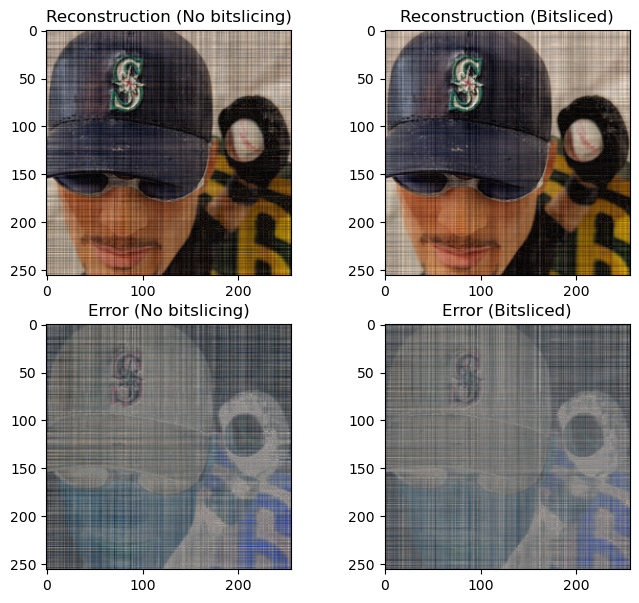

In [11]:
# Container for the 2D spectrum and reconstruction
reconstruction_xbar_bitsliced = np.zeros(ichiro.shape, dtype=np.complex128)

for ch in range(Nch):

    # Compute 2D DFT
    partial_dft = xbar_dft_bitsliced @ ichiro[:,:,ch]
    spectrum_ch = partial_dft @ xbar_dft_bitsliced

    # Compute 2D inverse DFT
    partial_idft = xbar_idft_bitsliced @ spectrum_ch
    reconstruction_xbar_bitsliced[:,:,ch] = partial_idft @ xbar_idft_bitsliced

# Plot the reconstructed image
reconstruction_xbar_bitsliced = np.abs(reconstruction_xbar_bitsliced)/np.max(np.abs(reconstruction_xbar_bitsliced))
error_bitsliced = reconstruction_xbar_bitsliced - ichiro + 0.5
fig,axes = plt.subplots(2,2,figsize=(8,7))
axes[0][0].imshow(reconstruction_xbar)
axes[0][0].set_title("Reconstruction (No bitslicing)")
axes[0][1].imshow(reconstruction_xbar_bitsliced)
axes[0][1].set_title("Reconstruction (Bitsliced)")
axes[1][0].imshow(error)
axes[1][0].set_title("Error (No bitslicing)")
axes[1][1].imshow(error_bitsliced)
axes[1][1].set_title("Error (Bitsliced)")
[ax.tick_params(labelsize=8) for ax in axes2]
plt.show()

## 1.4. Input quantization and analog-to-digital converter

Realistically, the analog PUM system needs to take digital inputs and produce digital outputs. We will specify the input numerical range and resolution, as well as the analog-to-digital converter (ADC) input current range and resolution.

We use an input range of (-1, +1) for each array. To account for the fact that each matmul in the 2D reconstruction has very different input ranges, we need to have a digital scaling/de-scaling step around each analog matmul. These scaling factors were roughly determined by inspecting the statistics of the inputs to each matmul.

We use ADCs with an input range of (-100, +100) in both the DFT and inverse DFT cores. These are normalized units in terms of the max current through a memory element. This was range was determined by a rough optimization process.

To keep things simpler, we will not use bit slicing.

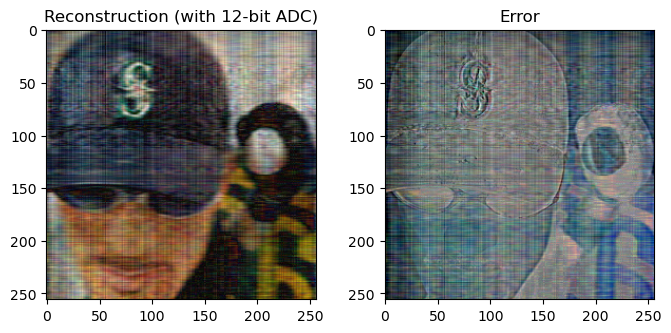

In [12]:
# Create the parameters for the core with programming errors
params_adc = set_params(
                            complex_matrix = True,
                            complex_input = True,
                            weight_bits = 8,
                            wtmodel = "BALANCED",
                            error_model = "generic",
                            proportional_error = True,
                            alpha_error = alpha,
                            Rmin = 1e3,
                            Rmax = 1e6,
                            input_range = (-1,1),
                            input_bits = 12,
                            adc_range = (-100,100),
                            adc_bits = 12,
                            )

xbar_dft_adc = AnalogCore(W_dft, params = params_adc)
xbar_idft_adc = AnalogCore(W_idft, params = params_adc)

# Numerical ranges for the intermediate results, used to scale the inputs to the analog MVMs
range_partial_dft = 300
range_spectrum = 30000
range_partial_idft = 2

reconstruction_xbar = np.zeros(ichiro.shape, dtype=np.complex128)

for ch in range(Nch):

    # Compute 2D DFT
    partial_dft = xbar_dft_adc @ ichiro[:,:,ch]
    partial_dft /= range_partial_dft
    spectrum_ch = partial_dft @ xbar_dft_adc

    # Compute 2D inverse DFT
    spectrum_ch *= range_partial_dft/range_spectrum
    partial_idft = xbar_idft_adc @ spectrum_ch
    partial_dft *= range_spectrum/range_partial_idft
    reconstruction_xbar[:,:,ch] = partial_idft @ xbar_idft_adc
    partial_dft *= range_partial_idft

# Plot the reconstructed image
reconstruction_xbar = np.clip(np.abs(reconstruction_xbar)/np.max(np.abs(reconstruction_xbar)),0,1)
error = np.clip(reconstruction_xbar - ichiro + 0.5,0,1)
fig,axes = plt.subplots(1,2,figsize=(8,3.5))
axes[0].imshow(reconstruction_xbar)
axes[0].set_title("Reconstruction (with 12-bit ADC)")
C1=axes[1].imshow(error)
axes[1].set_title("Error")
[ax.tick_params(labelsize=8) for ax in axes2]
plt.show()

Note that including quantization and clipping has reduced the quality of the image noticeably, even with 12-bit resolution in both the inputs and ADCs! Although the input and ADC ranges could have been optimized more, it does indicate that this application has potentially higher requirements than neural networks. This comes from two things: (1) the DFT has continuous outputs rather than neural network models which may have discrete outputs (e.g. classification), so errors are more apparent, and (2) the DFT matrix is dense, while neural network weight matrices tend to be more sparse. This leads to higher precision requirements for the same matrix size.

### 1.5 Parasitic resistance and matrix splitting

Besides device errors, another major source of errors in analog IMC is the parasitic resistance of the metal wires. To simulate the effect of array parasitics, CrossSim internally performs a fast circuit simulation on every MVM.
<br />
<br />

<img src="https://www.sandia.gov/app/uploads/sites/110/2023/09/parasitics.png" width=220 />

The circuit solver still slows things down compared to a simulation without parasitics, so for the sake of keeping this tutorial on time, we will evaluate on a simple 1D DFT example that uses only the real part of the DFT matrix.

Reduced MVM convergence parameter to: 0.81353


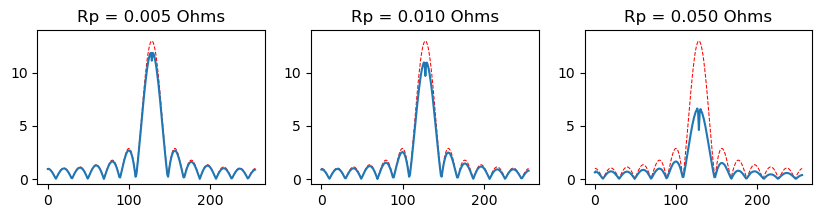

In [13]:
# DFT matrix (real only)
N_ft1 = 256
W = np.real(scipy.linalg.dft(N_ft1))
W = np.fft.fftshift(W, axes=[0]) # Shift DFT array so zero frequency is in the middle

# Rectangular pulse input
x = np.zeros(N_ft1)
x[(N_ft1//2-6):(N_ft1//2+7)] = 1

# Set parameters for core with and without parasitic resistance
Rp1 = 5e-3 # 0.005 ohms
Rp2 = 1e-2 # 0.010 ohms
Rp3 = 5e-2 # 0.050 ohms
base_args = {'input_range' : (0,1), 'wtmodel' : 'BALANCED', 'gate_input' : False, 
             'Rmin': 1e3, 'Rmax' : 1e6}
params_ideal = set_params(**base_args)
params_par1 = set_params(Rp_row = Rp1, Rp_col = Rp1, **base_args)
params_par2 = set_params(Rp_row = Rp2, Rp_col = Rp2, **base_args)
params_par3 = set_params(Rp_row = Rp3, Rp_col = Rp3, **base_args)

# Create an AnalogCore and program matrix
xbar_ideal = AnalogCore(W, params=params_ideal)
xbar_par1 = AnalogCore(W, params=params_par1)
xbar_par2 = AnalogCore(W, params=params_par2)
xbar_par3 = AnalogCore(W, params=params_par3)

# Use the AnalogCore like a NumPy array
y_ideal = xbar_ideal @ x
y_par1 = xbar_par1 @ x
y_par2 = xbar_par2 @ x
y_par3 = xbar_par3 @ x

fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(10,2))
for ax in (ax1,ax2,ax3):
    ax.plot(np.abs(y_ideal),'--r', linewidth=0.75)
    ax.set_ylim([-0.5,14])
ax1.plot(np.abs(y_par1))
ax2.plot(np.abs(y_par2))
ax3.plot(np.abs(y_par3))
ax1.set_title("Rp = {:.3f} Ohms".format(Rp1))
ax2.set_title("Rp = {:.3f} Ohms".format(Rp2))
ax3.set_title("Rp = {:.3f} Ohms".format(Rp3))
plt.show()


This MVM is sensitive to parasitic resistance. Although the memory devices have a resistance in the range from 1 k$\Omega$ to 1 M$\Omega$, the output is heavily distorted when the unit cell wire resistance is as small as 0.05$\Omega$!

This is because the matrix is somewhat large: 256$\times$256. By default, CrossSim will allocate an array that fits the whole matrix. This means large currents are flowing along the rows and/or columns. In this example, the voltage drops along the rows are the big problem since only a few rows along a column are activated. So we expect that splitting up the matrix into multiple arrays, partitioned along the column dimension to help a lot. Meanwhile, splitting by rows would help comparatively little.

In CrossSim we can easily partition a weight matrix across multiple physical arrays by setting a limit on the max number of rows and/or columns for the physical array. Let's see if reducing the array size reduces the effect of parasitic resistance.

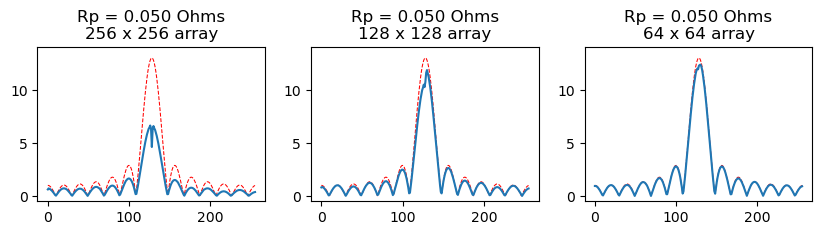

In [14]:
# Set parameters for core with and without parasitic resistance
Rp = 5e-2
base_args = {'input_range' : (0,1), 'wtmodel' : 'BALANCED', 'gate_input' : False, 
            'Rmin': 1e3, 'Rmax' : 1e6, 'Rp_row' : Rp, 'Rp_col' : Rp}
params_128 = set_params(NcolsMax = 128, NrowsMax = 128, **base_args)
params_64 = set_params(NcolsMax = 64, NrowsMax = 64, **base_args)

# Create an AnalogCore and program matrix
xbar_128 = AnalogCore(W, params=[params_128]*4)
xbar_64 = AnalogCore(W, params=[params_64]*16)

# Use the AnalogCore like a NumPy array
y_128 = xbar_128 @ x
y_64 = xbar_64 @ x

fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(10,2))
for ax in (ax1,ax2,ax3):
    ax.plot(np.abs(y_ideal),'--r', linewidth=0.75)
    ax.set_ylim([-0.5,14])
ax1.plot(np.abs(y_par3))
ax2.plot(np.abs(y_128))
ax3.plot(np.abs(y_64))
ax1.set_title("Rp = {:.3f} Ohms\n256 x 256 array".format(Rp))
ax2.set_title("Rp = {:.3f} Ohms\n128 x 128 array".format(Rp))
ax3.set_title("Rp = {:.3f} Ohms\n64 x 64 array".format(Rp))
plt.show()

Indeed, it looks like reducing the array size from 256$\times$256 to 64$\times$64 almost fully mitigates the effect of parasitic resistance, even though the 

### 1.6 Saving and loading core and simulation settings

The CrossSim Parameters object has a JSON interface that makes it easy to port the same core or simulation settings to a different script, codebase or machine. This also makes it easy to reproduce prior simulation results (up to the random seed).

Here, we show demonstrate the JSON interface by exporting the parameters we created in Section 2.5 for running a parasitic resistance simulation with a 64$\times$64 array. Then, we create a fresh CrossSimParameters object and load the parameters that are saved in the JSON file, and re-run the simulation.

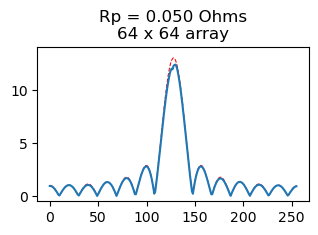

In [15]:
# Save the last used parameters to a JSON file
params_64.to_json("./params/params_64.json")

# Create a new parameters object
params_new = CrossSimParameters()

# Load the parameters from the JSON file
params_new = params_new.from_json("./params/params_64.json")

# Re-run the 64x64 parasitic resistance simulation with the new parameters object
xbar_64 = AnalogCore(W, params=[params_new]*16)
y_64 = xbar_64 @ x

fig, ax1 = plt.subplots(1,1,figsize=(3.5,2))
ax1.plot(np.abs(y_ideal),'--r', linewidth=0.75)
ax1.set_ylim([-0.5,14])
ax1.plot(np.abs(y_64))
ax1.set_title("Rp = {:.3f} Ohms\n64 x 64 array".format(Rp))
plt.show()

The results are identical to the output of the last code cell.

# Part 2: Neural network inference

For the next demonstration we'll show that we can easily take a trained PyTorch model and simulate the accuracy of neural network inference when executed on analog PUM hardware. CrossSim automatically stores the weights as memory device conductances, which can include errors, and simulates the analog matrix-vector multiplications that are needed for an inference operation.

We will use a ResNet trained on CIFAR-10 for this demo. First, we will import PyTorch and other required modules.

In [16]:
from simulator.algorithms.dnn.torch.convert import from_torch, reinitialize, synchronize
import torch
from torchvision import datasets, transforms
from applications.dnn.torch.cifar10_resnet.build_resnet_cifar10 import ResNet_cifar10

Next, we will create a standard PyTorch DataLoader for the CIFAR-10 test set.

In [17]:
# Number of CIFAR-10 test images to use for this demo (max 10000)
N_images = 5000

# Inference batch size
batch_size = 64

# Transform for Gaussian normalization of the dataset
normalize = transforms.Normalize(
    mean = [0.485, 0.456, 0.406],
    std  = [0.229, 0.224, 0.225])

# Create data loader
dataset = datasets.CIFAR10(root='./',train=False, download=True, 
    transform= transforms.Compose([transforms.ToTensor(), normalize]))
dataset = torch.utils.data.Subset(dataset, np.arange(N_images))
cifar10_dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)

Files already downloaded and verified


Now we will create the PyTorch model by passing a file containing the pre-trained weights into a standard PyTorch script that builds the ResNet. For this demo, we will use a ResNet-32.

In [18]:
resnet_model = ResNet_cifar10(2) # ResNet-32 has five residual blocks
resnet_model.load_state_dict(
    torch.load('../../applications/dnn/torch/cifar10_resnet/models/resnet14_cifar10.pth',
    map_location=torch.device('cpu')))
resnet_model = resnet_model.eval()

Now that we have our model and dataset, let's first run inference on it using PyTorch.

In [19]:
y_pred, y, k = np.zeros(N_images), np.zeros(N_images), 0
for inputs, labels in cifar10_dataloader:
    # Execute model
    output = resnet_model(inputs)
    # Collect outputs
    y_pred_k = output.data.detach().numpy()
    batch_size_k = y_pred_k.shape[0]
    y_pred[k:(k+batch_size_k)] = y_pred_k.argmax(axis=1)
    y[k:(k+batch_size_k)] = labels.detach().numpy()
    k += batch_size_k
    print("Image {:d}/{:d}, accuracy so far = {:.2f}%".format(
        k, N_images, 100*np.sum(y[:k] == y_pred[:k])/k), end="\r")

# Evaluate accuracy
top1 = np.sum(y == y_pred)/len(y)
print('Final accuracy: {:.2f}% ({:d}/{:d})\n'.format(top1*100,int(top1*N_images),N_images))

Final accuracy: 89.40% (4470/5000) 89.40%



Now let's see how this model would do with analog errors. For this, we'll import a set of AnalogCore hardware parameters that we've previously generated. This includes the mapping settings, device settings, and layer-specific input and ADC ranges. We will simulate inference with two custom device models: one for a ReRAM device (Milo et al, IRPS 2021) and one for a SONOS device (Agrawal et al, IEDM 2022). The two models are shown below:

<img src="./graphics/RRAM_SONOS.png" width=700 />

We'll load a list of parameters objects (one per layer) then look at the parameters for a layer in the middle of the network.

In [20]:
# Load all the parameters
params_list_RRAM = pickle.load(open("./params/resnet14_params_RRAMMilo.p","rb"))

# Show the parameters for layer 10
print(params_list_RRAM[10])

CrossSimParameters: 
{'core': {'balanced': {'interleaved_posneg': False,
                       'style': <BalancedCoreStyle.ONE_SIDED: 1>,
                       'subtract_current_in_xbar': True},
          'bit_sliced': {'num_slices': 2,
                         'style': <BitSlicedCoreStyle.BALANCED: 1>},
          'cols_max': 256,
          'complex_input': False,
          'complex_matrix': False,
          'mapping': {'inputs': {'_match': True,
                                 'mvm': {'clipping': False,
                                         'max': 7.751552602226406,
                                         'min': 0.0,
                                         'percentile': None},
                                 'vmm': {'clipping': False,
                                         'max': 7.751552602226406,
                                         'min': 0.0,
                                         'percentile': None}},
                      'weights': {'clipping': True,
          

In [21]:
# Convert the Conv2D and Linear layers in the PyTorch model to layers that use a CrossSim back-end
analog_resnet = from_torch(resnet_model, params_list_RRAM, fuse_batchnorm=True)

# Print a summary of the new PyTorch model
print(analog_resnet)

ResNet_cifar10(
  (conv1): AnalogConv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): Identity()
  (relu): ReLU(inplace=True)
  (res1): Sequential(
    (0): BasicBlock(
      (conv1): AnalogConv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): Identity()
      (relu): ReLU(inplace=True)
      (conv2): AnalogConv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): Identity()
    )
    (1): BasicBlock(
      (conv1): AnalogConv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): Identity()
      (relu): ReLU(inplace=True)
      (conv2): AnalogConv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): Identity()
    )
  )
  (res2): Sequential(
    (0): BasicBlock(
      (conv1): AnalogConv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): Identity()
      (relu): ReLU(inplace=True)
      (conv2): AnalogConv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), paddi

In [22]:
y_pred, y, k = np.zeros(N_images), np.zeros(N_images), 0
for inputs, labels in cifar10_dataloader:
    # Execute model
    output = analog_resnet(inputs)
    # Collect outputs
    y_pred_k = output.data.detach().numpy()
    batch_size_k = y_pred_k.shape[0]
    y_pred[k:(k+batch_size_k)] = y_pred_k.argmax(axis=1)
    y[k:(k+batch_size_k)] = labels.detach().numpy()
    k += batch_size_k
    print("Image {:d}/{:d}, accuracy so far = {:.2f}%".format(
        k, N_images, 100*np.sum(y[:k] == y_pred[:k])/k), end="\r")

# Evaluate accuracy
top1 = np.sum(y == y_pred)/len(y)
print("\n=================")
print('Final accuracy: {:.2f}% ({:d}/{:d})\n'.format(top1*100,int(top1*N_images),N_images))

Image 5000/5000, accuracy so far = 64.48%
Final accuracy: 64.48% (3224/5000)



With this device error model, the CIFAR-10 inference accuracy experienced quite a large drop. This is partly because the RRAM device model has relatively large programming errors across its entire conductance range.

Now we'll run the same inference simulation but swap out the device to use the SONOS device, but otherwise keep all the other hardware assumptions the same.

In [23]:
# Load the parameter list with SONOS
params_list_SONOS = pickle.load(open("./params/resnet14_params_SONOS.p","rb"))

# Create CrossSim-compatible PyTorch model with the new parameters
analog_resnet = from_torch(resnet_model, params_list_SONOS, fuse_batchnorm=True)

# Run simulation
y_pred, y, k = np.zeros(N_images), np.zeros(N_images), 0
for inputs, labels in cifar10_dataloader:
    # Execute model
    output = analog_resnet(inputs)
    # Collect outputs
    y_pred_k = output.data.detach().numpy()
    batch_size_k = y_pred_k.shape[0]
    y_pred[k:(k+batch_size_k)] = y_pred_k.argmax(axis=1)
    y[k:(k+batch_size_k)] = labels.detach().numpy()
    k += batch_size_k
    print("Image {:d}/{:d}, accuracy so far = {:.2f}%".format(
        k, N_images, 100*np.sum(y[:k] == y_pred[:k])/k), end="\r")

# Evaluate accuracy
top1 = np.sum(y == y_pred)/len(y)
print("\n=================")
print('Final accuracy: {:.2f}% ({:d}/{:d})\n'.format(top1*100,int(top1*N_images),N_images))

Image 5000/5000, accuracy so far = 88.86%
Final accuracy: 88.86% (4443/5000)



With the SONOS error model, the accuracy is nearly ideal! This is because this device has an error that goes to zero as the conductance approaches zero. For neural networks, most of the weight values are small, so this property is very beneficial for reducing accumulated analog errors.

# Part 3: Device-aware training

The PyTorch model with CrossSim-compatible layers are not just useful for running inference. They can be trained as well! In this use case, the forward pass through the convolution and fully-connected layers will be executed through CrossSim's AnalogCores, but the backward pass will be idealized, providing a differentiable trace. This means that, to the extent the idealized operation matches the true AnalogCore forward pass, we can perform surrogate gradient descent. This can allow a network to adapt to these non-idealities and recover some of the performance that would be lost from post-training conversion.

For this simple demo, we will train on the very simple MNIST dataset, with and without device errors in the loop injected through CrossSim. First, we will load the dataset.

In [24]:
from tqdm import tqdm
from pathlib import Path

# Load the MNIST training set
mnist_data = datasets.MNIST("./", download=True, train=True,
                              transform=transforms.ToTensor(),
                              target_transform=transforms.Compose([
                                lambda x:torch.tensor([x]), 
                                lambda x:torch.nn.functional.one_hot(x,10).float(),
                                lambda x:x.squeeze(),
                                ]))

# Load the MNIST test set
mnist_test = datasets.MNIST("./", download=True, train=False,
                              transform=transforms.ToTensor(),
                              target_transform=transforms.Compose([
                                lambda x:torch.tensor([x]), 
                                lambda x:torch.nn.functional.one_hot(x,10).float(),
                                lambda x:x.squeeze(),
                                ]))

# Split dataset into training and validation and create data loaders
ds_train, ds_val = torch.utils.data.random_split(mnist_data, [0.8, 0.2])
mnist_loader_train = torch.utils.data.DataLoader(ds_train, batch_size=batch_size, shuffle=True)
mnist_loader_val = torch.utils.data.DataLoader(ds_val, batch_size=batch_size, shuffle=False)

# Create test set loader
mnist_loader_test = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=False)
N_test = len(mnist_loader_test.dataset)

We will train a simple three-layer CNN on MNIST, whose topology is defined below. This is a small network with only 7018 trainable weights.

In [25]:
# Define the CNN topology
def mnist_cnn():
    return torch.nn.Sequential(
        torch.nn.Conv2d(1, 8, 3, padding='valid', stride=2),
        torch.nn.ReLU(),
        torch.nn.Conv2d(8, 16, 3, padding='valid', stride=2),
        torch.nn.ReLU(),
        torch.nn.Flatten(),
        torch.nn.Linear(576, 10)
        )

We will use the standard PyTorch wrapper below to train the CNN on MNIST. We will train using the Adam optimizer with a learning rate of $10^{-3}$.

In [26]:
# Wrapper for training the CNN
class SequentialWrapper():
    def __init__(self, net, loss, learning_rate=1e-3):
        self.net = net
        self.loss = loss
        self.learning_rate = learning_rate
        self.optimizer = torch.optim.Adam(self.net.parameters(), lr=self.learning_rate)

    def forward(self, x):
        return self.net(x)
    
    def training_step(self, batch):
        self.optimizer.zero_grad()
        pred = self.forward(batch[0])
        loss = self.loss(pred, batch[1])
        loss.backward()
        self.optimizer.step()
        return loss

    def validation_step(self, batch):
        pred = self.forward(batch[0])
        loss = self.loss(pred, batch[1])
        return loss
    
    def train_epoch(self, train_loader, val_loader):
        loss_train, loss_val = 0, 0
        for minibatch in iter(train_loader):
            loss_train += self.training_step(minibatch).detach()
        for minibatch in iter(val_loader):
            loss_val += self.validation_step(minibatch).detach()
        return loss_train/len(train_loader), loss_val/len(val_loader)
    
    def train(self, train_loader, val_loader, epochs):
        loss_train, loss_val = np.zeros(epochs), np.zeros(epochs)
        for e in tqdm(range(0, epochs)):
            lt, lv = self.train_epoch(train_loader, val_loader)
            loss_train[e] = lt
            loss_val[e] = lv
        return loss_train, loss_val

# Create the wrapped PyTorch model
mnist_cnn_pt = SequentialWrapper(mnist_cnn(), torch.nn.CrossEntropyLoss())

We will first train this CNN as we would normally do in PyTorch, without any analog error injection during training. After training, we'll evaluate the test accuracy, again without any analog errors.

In [27]:
# Number of training epochs
N_epochs = 20

# Train the standard PyTorch CNN
loss_train_pt, loss_val_pt = mnist_cnn_pt.train(mnist_loader_train, mnist_loader_val, N_epochs)

# Perform inference on the test set, with no analog errors
y_pred, y, k = np.zeros(N_test), np.zeros(N_test), 0
for inputs, labels in mnist_loader_test:
    output = mnist_cnn_pt.net(inputs)
    y_pred_k = output.data.detach().numpy()
    y_pred = np.append(y_pred,y_pred_k.argmax(axis=-1))
    y = np.append(y,labels.detach().numpy().argmax(axis=1))

# Evaluate accuracy
accuracy_digitalTrain_digitalTest = np.sum(y == y_pred)/len(y)
print('===========')
print('No analog errors during training, no analog errors during test')
print('Test accuracy: {:.2f}%\n'.format(accuracy_digitalTrain_digitalTest*100))

100%|████████████████████████████████████████████████████████████████████████| 20/20 [02:33<00:00,  7.65s/it]


No analog errors during training, no analog errors during test
Test accuracy: 98.98%



How well does this CNN do when analog errors are injected at inference time? Since this is MNIST, we will simulate inference assuming a memory device that has very large errors. This device will have state-independent conductance errors with $\alpha = 0.3$. We will disable all other error models to keep this demo simple.

We will run inference by first passing our trained CNN through our PyTorch layer converter as we did in Part 2. Since the device error is large, we will simulate inference ten times with re-sampled random device errors each time. This will give us a good statistical picture of the network's accuracy.

In [28]:
# Create a parameters object that models a memory device with very large errors
params_analog = set_params(weight_bits = 8, wtmodel = "BALANCED", 
                         error_model = "generic",
                         proportional_error = "False",
                         alpha_error = 0.3)

# Convert the layers in the trained CNN
analog_mnist_cnn_pt = from_torch(mnist_cnn_pt.net, params_analog)

# Number of inference simulations with re-sampled random analog errors
N_runs = 10

# Perform analog inference on the test set
accuracies = np.zeros(N_runs)
for i in range(N_runs):
    print("Inference simulation {:d} of {:d}".format(i+1,N_runs), end="\r")
    y_pred, y, k = np.zeros(N_test), np.zeros(N_test), 0
    for inputs, labels in mnist_loader_test:
        output = analog_mnist_cnn_pt.forward(inputs)
        y_pred_k = output.data.detach().numpy()
        y_pred = np.append(y_pred,y_pred_k.argmax(axis=-1))
        y = np.append(y,labels.detach().numpy().argmax(axis=1))
    accuracies[i] = np.sum(y == y_pred)/len(y)
    reinitialize(analog_mnist_cnn_pt)

# Evaluate average test accuracy
print('\n===========')
print('No analog errors during training, CrossSim analog errors during test')
accuracy_digitalTrain_analogTest = np.mean(accuracies)
std_digitalTrain_analogTest = np.std(accuracies)
print('Test accuracy: {:.2f}% +/- {:.3f}%'.format(100*accuracy_digitalTrain_analogTest,100*std_digitalTrain_analogTest))

Inference simulation 10 of 10
No analog errors during training, CrossSim analog errors during test
Test accuracy: 93.74% +/- 1.147%


With the inclusion of these large conductance errors, our model loses quite a bit of accuracy on MNIST.

Now let's try to see if we can make up this accuracy loss by simulating the conductance errors at inference time during the training process. As before, we will disable all other error models to keep things simple. For a practical hardware-aware training scenario, we can specify our parameters to represent the exact analog hardware configuration that would be used during inference and enable as many different error models in CrossSim as we would like.

To do this, we will use a modified training wrapper below that includes only a single new line. The "synchronize" method is called after the backward pass to update the conductance values in the AnalogCores with the new updated weight values found using the optimizer. These updated AnalogCores will then be used for the forward pass of the next training epoch.

We create another PyTorch CNN, convert its layers to be CrossSim-compatible, then wrap it with the modified training wrapper. Then we will train this model with the same large conductance errors injected during training.

In [29]:
# Modified training warpper for CrossSim-in-the-loop training
class SequentialWrapper_CrossSim(SequentialWrapper):
    def __init__(self, net, loss, learning_rate=1e-3):
        super().__init__(net, loss, learning_rate)
        
    def training_step(self, batch):
        self.optimizer.zero_grad()
        pred = self.forward(batch[0])
        loss = self.loss(pred, batch[1])
        loss.backward()
        self.optimizer.step()
        synchronize(self.net)  # <--- The only changed line in all of training!
        return loss

# Create a PyTorch model with CrossSim-compatible layers
analog_mnist_cnn = from_torch(mnist_cnn(), params_analog)

# Create the wrapped analog PyTorch model
analog_mnist_cnn_CS = SequentialWrapper_CrossSim(analog_mnist_cnn, torch.nn.CrossEntropyLoss())

# Train the analog PyTorch model
loss_train_CS, loss_val_CS = analog_mnist_cnn_CS.train(mnist_loader_train, mnist_loader_val, N_epochs)

100%|████████████████████████████████████████████████████████████████████████| 20/20 [08:20<00:00, 25.01s/it]


Finally, let's perform inference simulation with conductance errors to see if our model that had device-aware training (with the same conductance errors as inference) achieves higher accuracy than the model with standard training.

In [30]:
# Perform analog inference on the test set
accuracies = np.zeros(N_runs)
for i in range(N_runs):
    print("Inference simulation {:d} of {:d}".format(i+1,N_runs), end="\r")
    y_pred, y, k = np.zeros(N_test), np.zeros(N_test), 0
    for inputs, labels in mnist_loader_test:
        output = analog_mnist_cnn_CS.net(inputs)
        y_pred_k = output.data.detach().numpy()
        y_pred = np.append(y_pred,y_pred_k.argmax(axis=-1))
        y = np.append(y,labels.detach().numpy().argmax(axis=1))
    accuracies[i] = np.sum(y == y_pred)/len(y)
    reinitialize(analog_mnist_cnn_CS.net)

# Evaluate average test accuracy
print('\n===========')
print('CrossSim analog errors during training, CrossSim analog errors during test')
accuracy_analogTrain_analogTest = np.mean(accuracies)
std_analogTrain_analogTest = np.std(accuracies)
print('Test accuracy: {:.2f}% +/- {:.3f}%'.format(accuracy_analogTrain_analogTest*100,std_analogTrain_analogTest*100))

Inference simulation 10 of 10
CrossSim analog errors during training, CrossSim analog errors during test
Test accuracy: 97.62% +/- 0.215%


Let's summarize our results.

In [31]:
print("Accuracy on MNIST test set")
print("================")
print("Standard training, standard inference: {:.2f}%".format(100*accuracy_digitalTrain_digitalTest))
print("Standard training, CrossSim inference: {:.2f}% +/- {:.3f}%".format(100*accuracy_digitalTrain_analogTest, 100*std_digitalTrain_analogTest))
print("CrossSim training, CrossSim inference: {:.2f}% +/- {:.3f}%".format(100*accuracy_analogTrain_analogTest, 100*std_analogTrain_analogTest))

Accuracy on MNIST test set
Standard training, standard inference: 98.98%
Standard training, CrossSim inference: 93.74% +/- 1.147%
CrossSim training, CrossSim inference: 97.62% +/- 0.215%


Device-aware training using CrossSim yielded a substantial recovery of the test accuracy in the presence of very large conductance errors!